## Scratchpad

### For implementing model discussed in Geisler, 1984

In [1]:
import numpy as np
import helper_fcns as hf
from scipy.stats import poisson
import autoreload
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf as pltSave
import pandas as pd
import seaborn as sns
%matplotlib inline

#### Checking figure 1

In [28]:
x = np.linspace(-4.25, 4.25, 101)
lsf = hf.linespread_function(x)

The following function does not have the same amplitude as the one shown in the figure. However, I'm pretty sure this is because the one in the figure is just re-scaled so that its maximum value is 1 (hence the label of relative amplitude). Based on the figure legend ("the actual point-spread function was obtained from the smooth curve by assuming that the eye is isotropic and by normlizing the total volume under the function to 1.0"), I believe the following is correct for the calculations.

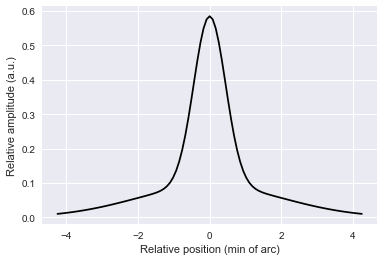

In [29]:
plt.plot(x, lsf, 'k')
#plt.ylim(0, 1.10)
plt.xlabel('Relative position (min of arc)')
_=plt.ylabel('Relative amplitude (a.u.)')

#### Point-spread function

Note: In the text, we assume the optics are isotropic, as in same everywhere. Thus, we can assume that the linespread function "generalizes" radially, and thus we use a 2D, radially symmetric gaussian to go from line-spread to point-spread

In [30]:
psf = hf.pointspread_function(x, x)

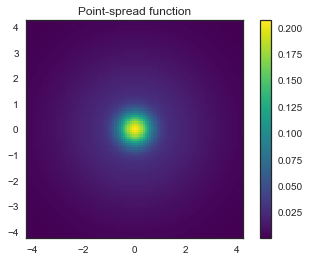

In [33]:
sns.set_style('white')
plt.imshow(psf, extent=[-4.25, 4.25, -4.25, 4.25], cmap='viridis');
plt.title('Point-spread function')
plt.colorbar()

#### Plotting a Poisson distribution

The number of photoreceptors absorbed is described by the poisson density, based on some mean number of quanta absorbed (see the next section)

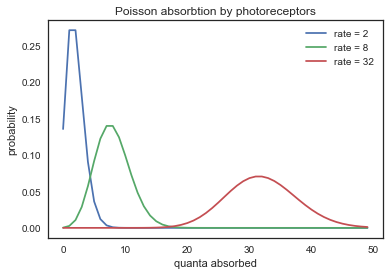

In [34]:
n_absorbed = np.arange(0, 50) # poisson process must have non-negative integer evaluations only!
labels = []
# rate is the mean number of quanta absorbed
for rate in [2, 8, 32]:
    plt.plot(n_absorbed, poisson.pmf(n_absorbed, rate))
    labels.append("rate = %s" % rate)
plt.legend(labels)
plt.xlabel('quanta absorbed')
plt.ylabel('probability')
_=plt.title('Poisson absorbtion by photoreceptors')

#### Creating the hexagonal photoreceptor lattice

Since this is a hexagonal lattice, the center-to-center distances of any three neighboring cones form an equilateral triangle. We also know that this distance (equivalently, the diameter of the receptors) is .6 arcminutes.

Therefore (using some basic trigonometry: $\tan(\frac{\pi}{3})=\sqrt{3}$), if the center of one receptor is at the point $(0,0)$, then the neighboring receptors have centers at: $(.6, 0), (.3, .3\sqrt{3}), (-.3, .3\sqrt{3}), (-.6, 0), (-.3, -.3\sqrt{3}), (.3, -.3\sqrt{3})$

In [63]:
lattice, xmin, ymin, x_lattice, y_lattice = hf.construct_photoreceptor_lattice(13.,)

When the lattice gets big, it needs to be plotted on a larger and larger figsize, otherwise some of the points won't get plotted. The following `np.sum` confirms that the correct number of centers were added (though it does nothing to determine if they were correctly placed)

In [64]:
np.sum(lattice)

169.0

If we drew circles and the triangle on this, we could make this look like figure 2

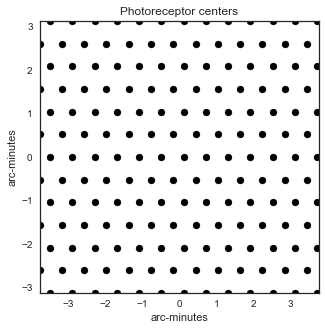

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
hf.visualize_receptor_lattice(lattice, x, y, cmap='gray');
plt.xlabel('arc-minutes'); plt.ylabel('arc-minutes');
plt.title('Photoreceptor centers', fontsize='large');

#### Calculating mean absorbtion

In [66]:
# for creating luminance signal - just a point source
lum = 3; # in cd/m2
psf = hf.pointspread_function(x_lattice, y_lattice)

col_labels = ['receptor area', 'stimulus duration', 'pupil area', 'ocular media transittance', 'photoreceptor efficiency', 'label', 'mean photons absorbed by center photoreceptor']
values = [[.28, .2, 3.1416, .68, .5, 'default'],
          [.28, .5, 3.1416, .68, .5, 'more time'],
          [.28, .2, 3.1416, .68, .9, 'more efficient'],
          [.2, .2, 3.1416, .68, .5, 'smaller receptors']]
df = []

for i, (a, d, s, t, e, label) in enumerate(values):
    retinal_image = hf.retinal_image(lum, psf)
    photoreceptor_absorptions = hf.mean_photons_absorbed(retinal_image, lattice, a, d, s, t, e)
    df.append(pd.DataFrame(dict((col, val) for val, col in zip([a, d, s, t, e, label, photoreceptor_absorptions[hf.get_middle(photoreceptor_absorptions)]], col_labels)), index=[i]))

df = pd.concat(df)
df['percent default'] = 100 * df['mean photons absorbed by center photoreceptor'] / df[df.label=='default']['mean photons absorbed by center photoreceptor'].values

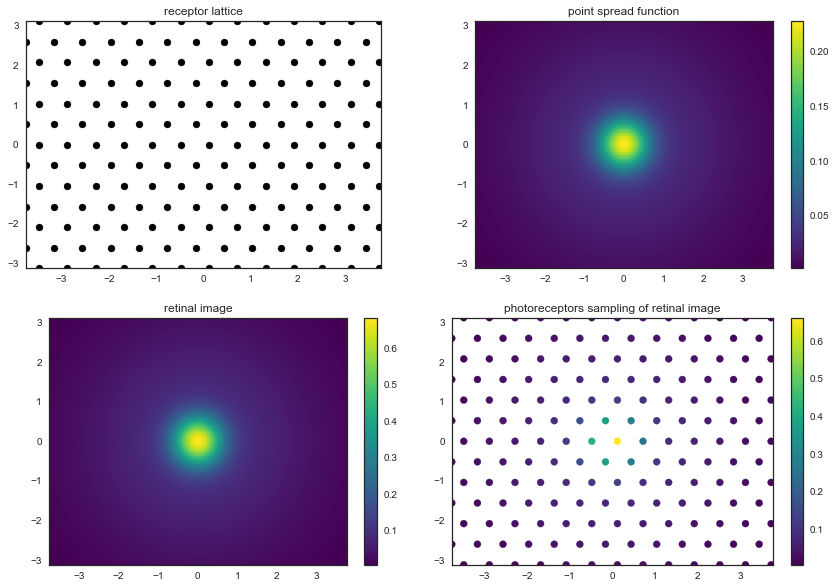

In [68]:
data = [lattice, psf, retinal_image, retinal_image * lattice]
titles = ['receptor lattice', 'point spread function', 'retinal image', 'photoreceptors sampling of retinal image']
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
for i, (im, title, ax) in enumerate(zip(data, titles, axes.flatten())):
    if i in [1, 2]:
        plotted = ax.imshow(im, extent=[-xmin, xmin, -ymin, ymin], cmap='viridis', aspect='equal')
    elif i in [0, 3]:
        plotted = hf.visualize_receptor_lattice(im, x, y, ax=ax, cmap='viridis')
    if i in [1,2,3]:
        plt.colorbar(plotted, ax=ax, fraction=.046)
    ax.set_title(title)

The following aren't surprising: the mean absorbtion is linear in all parameters a, d, s, t, e 

In [69]:
df

,label,mean photons absorbed by center photoreceptor,ocular media transittance,photoreceptor efficiency,pupil area,receptor area,stimulus duration,percent default
0,default,13.780733,0.68,0.5,3.1416,0.28,0.2,100.000000
1,more time,34.451833,0.68,0.5,3.1416,0.28,0.5,250.000000
2,more efficient,24.805320,0.68,0.9,3.1416,0.28,0.2,180.000000
3,smaller receptors,9.843381,0.68,0.5,3.1416,0.20,0.2,71.428571


Now, we can compare distributions: how discriminable will these be?

I think the first plot here is correct, because the units are in actual quanta of photons absorbed, rather than in what percentage that is of the original.

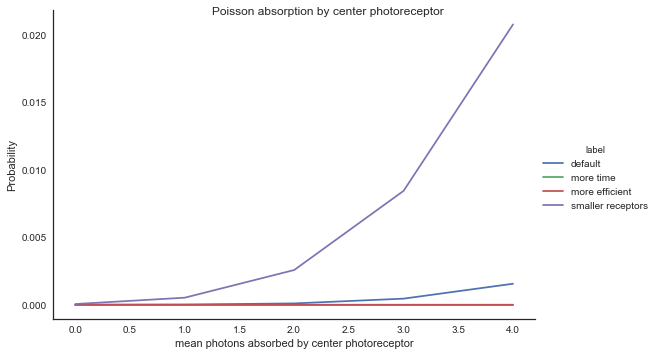

In [71]:
n_absorbed = np.arange(0, 5)
def absorption_plot(mean_absorbed, **kwargs):
    plt.plot(n_absorbed, poisson.pmf(n_absorbed, mean_absorbed), **kwargs)
g = sns.FacetGrid(df, hue='label', size=5, aspect=1.5)
g.map(absorption_plot, 'mean photons absorbed by center photoreceptor')
g.fig.suptitle('Poisson absorption by center photoreceptor')
g.set_ylabels('Probability')
g.add_legend();

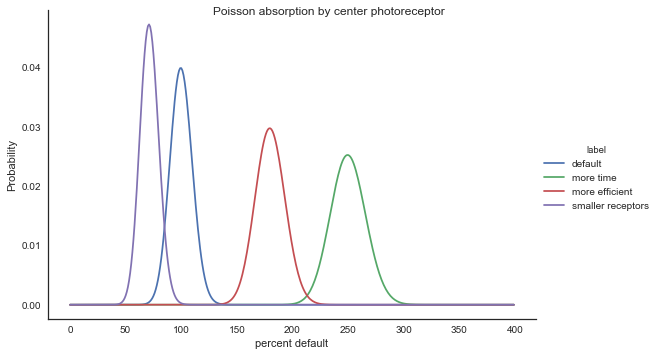

In [73]:
n_absorbed = np.arange(0, 400)
def absorption_plot(mean_absorbed, **kwargs):
    plt.plot(n_absorbed, poisson.pmf(n_absorbed, mean_absorbed), **kwargs)
g = sns.FacetGrid(df, hue='label', size=5, aspect=1.5)
g.map(absorption_plot, 'percent default')
g.fig.suptitle('Poisson absorption by center photoreceptor')
g.set_ylabels('Probability')
g.add_legend();

#### Generate figure 4

The numbers here don't line up. See the following graph.

Here, we're try to recreate Figure 4, finding the relationship between $N$ and $\Delta N$, where $N$ is the "mean number of quanta per stimulus", or $\sum_i\frac{\beta_i+\alpha_i}{2}$ and $\Delta N$ is the "average difference in number of effectively absorbed quanta from stimuli $\alpha$ and $\beta$ or $\sum_i\beta_i-\alpha_i$ when $d'=1.36$, at threshold. The line for our solution is consistently above Geisler's and it's not clear whether ours is correct.

I think it is, because our lies on the line given by $\delta N=1.36\sqrt{N}$, which Geisler says is the correct solution. However, I'm not sure what the base of the logarithm used in the plot is. Presumably, it's the natural logarithm, which is shown below, but the position of our line (and the $\delta N=1.36\sqrt{N}$ line) shifts around if a different base is used. But no reasonable value (2, 10, $e$) makes them line up, so I don't think that's the issue.

/home/billbrod/Documents/vis-mod-course/Geisler1984/helper_fcns.py:423: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(x), np.log10(y), 'k--', label='$\Delta N = 1.36\sqrt{N}$')


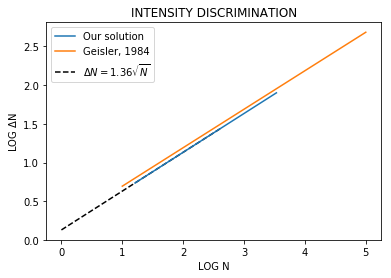

In [8]:
solts = hf.figure4([.2, .5, .75, 1, 2, 3, 4, 5, 6, 10, 15, 20, 50], 1.36);

#### Resolution task

In [10]:
autoreload.reload(hf)

<module 'helper_fcns' from '/home/billbrod/Documents/vis-mod-course/Geisler1984/helper_fcns.py'>

In [19]:
d_prime, photon_abs, delTheta_arcMin, ret_a, ret_b, lat, x_lattice, y_lattice = hf.resolution_task(1, 5, debug=True)
ret_a_abs = hf.retina_photons_absorbed(ret_a, lat)
ret_b_abs = hf.retina_photons_absorbed(ret_b, lat)
a = hf.mean_photons_absorbed(ret_a, lat)
b = hf.mean_photons_absorbed(ret_b, lat)

/home/billbrod/Documents/vis-mod-course/Geisler1984/helper_fcns.py:94: UserWarning: x has no middle index, returning the floor instead
  warnings.warn("x has no middle index, returning the floor instead")


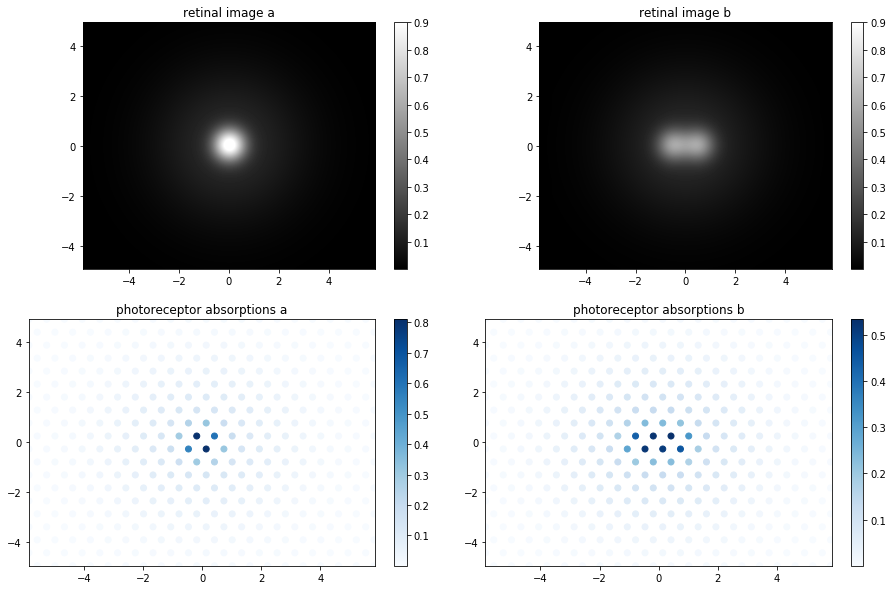

In [20]:
x_minutes = x_lattice.max()
y_minutes = y_lattice.max()
fig, axes = plt.subplots(2, 2, figsize=(15, 10), squeeze=True)
for ax, im, title in zip(axes.flatten(), [ret_a, ret_b, ret_a_abs, ret_b_abs], ['retinal image a', 'retinal image b', 'photoreceptor absorptions a', 'photoreceptor absorptions b']):
    if 'retinal' in title:
        plotted = ax.imshow(im, cmap='gray', extent=[-x_minutes, x_minutes, -y_minutes,y_minutes], vmax=.9)
    else:
        plotted = hf.visualize_receptor_lattice(im, x_lattice, y_lattice, ax=ax, cmap='Blues')
    plt.colorbar(plotted, ax=ax, fraction=.04)
    ax.set_title(title)

We unfortunately can't use the interpolated $\Delta\theta$ to generate figure 5, because we don't know what it's $N$ would be. Thus we have to use the "pixellated" $\Delta\theta$.

And our slope is still wrong. It looks like our estimations of the $\Delta\theta$ for low $N$ is what's causing the issue; the higher ones seem pretty close.

In [24]:
hf.optimize_resolution_task(1, init_deltaThetaPix=46, scale_factor=0, init_step_size=8)

/home/billbrod/Documents/vis-mod-course/Geisler1984/helper_fcns.py:94: UserWarning: x has no middle index, returning the floor instead
  warnings.warn("x has no middle index, returning the floor instead")


Interpolated delta theta 0.9105314041732673


[1.308525430705006, 66.91728633726339, 0.9]

In [94]:
autoreload.reload(hf)

<module 'helper_fcns' from '/home/billbrod/Documents/vis-mod-course/Geisler1984/helper_fcns.py'>

In [93]:
hf.optimize_resolution_task(10)

      fun: 8.400643728368555e-13
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-9.52221216e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 18
      nit: 6
   status: 0
  success: True
        x: array([0.48247013])

In [ ]:
solts = hf.figure5()

/home/billbrod/Documents/vis-mod-course/Geisler1984/helper_fcns.py:19: UserWarning: x has no middle index, returning the floor instead
  warnings.warn("x has no middle index, returning the floor instead")


Interpolated delta theta 11.937720989766682
Interpolated delta theta 3.53208464090931
Interpolated delta theta 2.210367933093382
Interpolated delta theta 1.137057226583645
Interpolated delta theta 0.9155316669563905
Interpolated delta theta 0.5827284708585301
Interpolated delta theta 0.4700518925406157
Interpolated delta theta 0.4111725645778153
Interpolated delta theta 0.3706331696240981


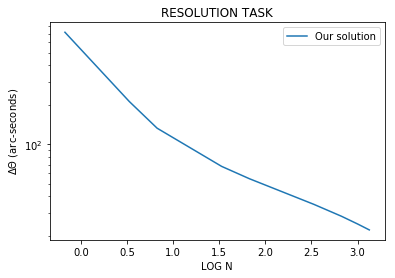

In [257]:
solts = hf.figure5(scale_factor=1)

In [121]:
solts

array([[1.35976966e+00, 6.66551317e-01, 1.19244955e+01],
       [1.35119396e+00, 3.33335282e+00, 3.49398745e+00],
       [1.36562057e+00, 6.67503042e+00, 2.21659435e+00],
       [1.27957801e+00, 3.34557695e+01, 1.08457082e+00],
       [1.30852543e+00, 6.69172863e+01, 9.10712872e-01],
       [1.22202055e+00, 3.35237024e+02, 5.24156033e-01],
       [1.32803728e+00, 6.70487490e+02, 4.40641584e-01],
       [1.23689279e+00, 1.00574325e+03, 3.60330183e-01],
       [1.16199780e+00, 1.34402607e+03, 1.28662491e-01]])

### Testing a better PSF/Gaussian sampling

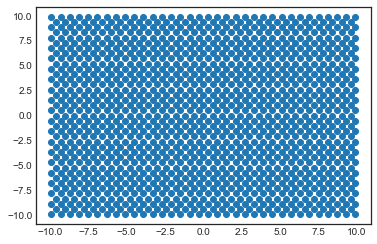

In [48]:
photoreceptors = hf.get_photoreceptor_locations(10, 10);
plt.scatter(photoreceptors[:,0], photoreceptors[:,1]);

g1: The "central" PSF without scaling

g2, g3: The two components which comprise the second, separated image/PSF; again, unscaled

In [49]:
deltaTheta = 11.9377
g1 = hf.Pointspread_Function((0,0))
g2 = hf.Pointspread_Function((-deltaTheta/2., 0))
g3 = hf.Pointspread_Function((deltaTheta/2., 0))

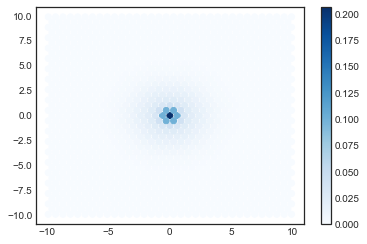

In [50]:
absorbed = g1.pdf(photoreceptors[:, 0], photoreceptors[:, 1]);
sns.set_style('white')
plt.scatter(photoreceptors[:, 0], photoreceptors[:, 1], c=absorbed, cmap='Blues', vmin=0)
plt.colorbar()

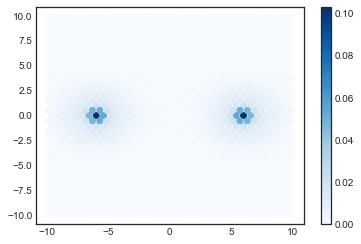

In [51]:
absorbed = .5*g2.pdf(photoreceptors[:, 0], photoreceptors[:, 1]) + .5*g3.pdf(photoreceptors[:,0], photoreceptors[:,1])
sns.set_style('white')
plt.scatter(photoreceptors[:, 0], photoreceptors[:, 1], c=absorbed, cmap='Blues', vmin=0)
plt.colorbar()